## Robot Learning

### Introduction

On this project, we will use an environment from [OpenAi Gym](https://gym.openai.com/).

In [2]:
!apt-get -qq install python-opengl xvfb x11-utils &> /dev/null
!pip install ufal.pybox2d --quiet &> /dev/null
!pip install pyvirtualdisplay moviepy pyglet PyOpenGL-accelerate --quiet &> /dev/null

The following cell imports packages required for the task. 

In [3]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import torch
import torch.nn as nn
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

  from scipy.ndimage.filters import sobel



## Lunar Lander

In this task, we will combine an actor-critic method with a policy gradient algorithm to control an agent in a challenging environment: the Lunar Lander. 

In [4]:
# set up showing animations from the environment in Colab.
Display(visible=False).start()

Examine the code cell below. It has two distinct purposes:

* Showcase the agent-environment interaction for LunarLander-v2

* Show how you can capture frames from this environment to animate an episode afterwards.

Note that for training an agent in this environment, it is advisable to omit all code corresponding to the rendering.

In [5]:
# Name of the environment, if you are having problems you can switch to 'CartPole-v1', which is easier to solve.
ENV_NAME = 'LunarLander-v2' #'CartPole-v1' 
# Dimension of the LunarLander state space. For 'CartPole-v1', use 4 instead
ENV_STATE_DIM =  8 # 4
# Lunar Lander has 4 discrete actions: [Do Nothing, Fire Left Booster, Fire Main Engine, Fire Right Booster], 'CartPole-v1' has 2
ENV_ACTION_DIM = 4 # 2
# If the agent reaches this score the task is seen as solved
SCORE_TO_SOLVE = 200 # 195
MAX_STEPS = None # 500
# Create the environment
env = gym.make(ENV_NAME)
# Reset the environment
state = env.reset() # state = [x, y, dx, dy, theta, dtheta, leg1_contact, leg2_contact]
# Track whether the episode is over
done = False
# List to append the frames produced by the environment renderer
frames = []
while not done:
  # Render current situation and append to frames
  frames.append(env.render('rgb_array'))
  # Select a random action
  action = env.action_space.sample()
  # Execute this action
  state, reward, done, info = env.step(action)
# Print the number of frames
print('Number of frames:', len(frames))
# Prevent the renderer from showing artifacts
plt.close()

Number of frames: 119


In [6]:
# Helper function to animate a list of frames as produced above
def visualize_trajectory(frames, fps=50):
  duration = int(len(frames) // fps + 1)
  fig, ax = plt.subplots()
  def make_frame(t, ind_max=len(frames)):
      ax.clear()
      ax.imshow(frames[min((int(fps*t),ind_max-1))])
      return mplfig_to_npimage(fig)
  plt.close()
  return VideoClip(make_frame, duration=duration)

In [7]:
# Get the animation from the frames of the played episode
animation = visualize_trajectory(frames)
# Show the animation
animation.ipython_display(fps=50, loop=True, autoplay=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Probably, the random agent will destroy itself instead of landing between the two flags. We would like you to improve upon this. Below, you are given a neural net with learnable weights $\theta$ which takes an environment state $s_t$ as input and can output either a state value $V_{\theta}(s_t)$ or a probability distribution over the actions $\pi_{\theta}(s_t,a)$. 

In [8]:
# If you feel like it, you can, but you do not need to adapt this
class DualNet(nn.Module):
    def __init__(self, state_dim=ENV_STATE_DIM, action_dim=ENV_ACTION_DIM, hidden_layer_dim=42):
        super(DualNet, self).__init__()
        # Create some layers to encode the input state
        self.layers = [nn.Linear(state_dim, hidden_layer_dim),
                       nn.LeakyReLU()]
        # Combine these layers into a net
        self.net = nn.Sequential(*self.layers)
        # Critic output layers to estimate V from the state encoding
        self.critic = nn.Sequential(*[nn.Linear(hidden_layer_dim,1)])
        # Actor output layers to estimate pi from the state encoding
        self.actor = nn.Sequential(*[nn.Linear(hidden_layer_dim,action_dim),
                                        nn.Softmax(dim=-1)])
    def forward(self, s, mode):
        # Convert input state to tensor
        x = torch.tensor(s).float().view(1,-1)
        # Encode state
        x = self.net(x)
        if mode == 'actor':
          # Return probability distribution over actions
          x = self.actor(x)
        else:
          # Return estimate of state value
          x = self.critic(x)
        return x.squeeze()

# Example usage:
# Create instance of the DualNet class
test_net = DualNet()
# Create a dummy state, round just for pretty printing
test_input = np.around(np.random.rand(ENV_STATE_DIM),2)
# Get the actor output
actor_out = test_net(test_input, mode='actor')
# Get the critic output
critic_out = test_net(test_input, mode='critic')
print('Dummy Input:', test_input)
print('Actor output:', actor_out)
print('Critic output:', critic_out)

Dummy Input: [0.15 0.25 0.71 0.86 0.06 0.37 0.79 0.21]
Actor output: tensor([0.2951, 0.2119, 0.2636, 0.2294], grad_fn=<SqueezeBackward0>)
Critic output: tensor(0.1710, grad_fn=<SqueezeBackward0>)


Now to the task: We play episodes according to the following scheme:

* For each visited state $s_t$, store the output of the critic $V_\theta(s_t)$ in a list.

* Select an action $a_t$ by sampling from the distribution $\pi_{\theta}(s_t,a)$ output by the actor. In a list, store the log prob of the action: $l_t = log(\pi_{\theta}[s_t,a_t])$. 

* Execute the action and observe the reward $r_{t+1}$ provided by the environment.

After each episode, we use the stored rewards to calculate the Returns $R_t$ following each state $s_t$ using the discount factor $\gamma$. Next, we calculate for each $t$

$$\delta_t = R_t - V_{\theta}(s_t)$$

Then, we calculate the loss of the critic as

$$L_{critic} = 0.5 \sum_t \delta_t^2$$

and the loss of the actor using the log probs as

$$L_{actor} = \sum_t - l_t  \delta_t$$

and finally the total loss

$$L = L_{critic} + L_{actor}$$

Now, we update the parameters $\theta$ using

$$\theta \leftarrow \theta + \alpha \nabla_{\theta}L$$

The Lunar Lander problem is considered solved when the agent achieves an average return of 200 over 100 episodes. 


2991: Average Return: 158.50: 100%|██████████| 3000/3000 [17:08<00:00,  2.92it/s]


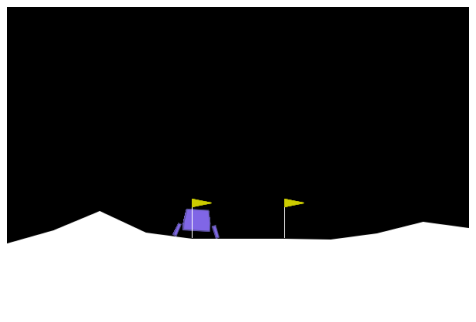

Average Return of the Final 100 Episodes: 160.80082963095475


In [9]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

 # Create the environment
env = gym.make(ENV_NAME)
# Get the combined actor and critic model
net = DualNet()
# Number of episodes to play, maybe use fewer at first
num_iter = 3000
# Learning rate for the parameter updates
alpha = 2e-2
# Discount factor
gamma = 0.99
# The optimizer will do the gradient updates for you
# It needs the trainable parameters and a learning rate
optimizer = torch.optim.RMSprop(net.parameters(), lr=alpha)

# This progress_bar is useful to know how far along the training is
progress_bar = tqdm(range(num_iter), total=num_iter, position=0, leave=True)

# List to store the returns of the final 100 episodes
returns_list = []

# For each episode (episode can be used like an int)
for episode in progress_bar:
    # Reset the accumulated gradients of the model parameters
    optimizer.zero_grad()
    # Reset the environment and observe the starting state
    s = env.reset()
    done = False
    # Collect the following terms during the episode
    rewards = []
    state_vals = []
    log_probs = []
    while not done:
        # During each Episode:
        # Evaluate the critic for s, store it
        state_val = net(s, mode='critic')
        state_vals.append(state_val)

        # Evaluate the actor for s
        action_probs = net(s, mode='actor')

        # Sample a from the distribution given by the actor
        action = np.random.choice(np.arange(ENV_ACTION_DIM), p=action_probs.detach().numpy())

        # Store log_prob of a
        log_prob = torch.log(action_probs[action])
        log_probs.append(log_prob)

        # Execute action a, observe next state, reward, and done
        s, r, done, _ = env.step(action)

        # Store the reward
        rewards.append(r)

    # After each episode is done
    # Calculate the Returns from the episode. Use rewards and gamma
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)

    # Standardize the Returns
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / returns.std()

    # Calculate delta_t, L_actor, L_critic
    if len(state_vals) > 0:
      state_vals_cat = torch.cat([torch.unsqueeze(tensor, 0) for tensor in state_vals])
    else:
      state_vals_cat = torch.tensor([])

    if len(log_probs) > 0:
      log_probs_cat = torch.cat([torch.unsqueeze(tensor, 0) for tensor in log_probs])
    else:
      log_probs_cat = torch.tensor([])

    L_critic = 0.5 * torch.sum((returns - state_vals_cat) ** 2)
    L_actor = -torch.sum(log_probs_cat * returns)



    # Calculate the loss L
    L = L_critic + L_actor
    # Set the gradients with respect to the parameters
    L.backward()
    # Update the parameters based on the gradients
    optimizer.step()

    # Calculate the return of the current episode
    episode_return = sum(rewards)
    returns_list.append(episode_return)

    # If you want your progress bar to print info, you can use the following template
    # How often to update info
    if episode % 10 == 0:
        # When to first update info
        if episode > 99:
            # List of strings containing info
            episode_summary = [f"{episode+1}: Average Return: {np.mean(returns_list[-100:]):.2f}"] + []
            # Set progress bar
            progress_bar.set_description("".join(episode_summary))

# Calculate the average return of the final 100 episodes
average_return = np.mean(returns_list[-100:])

# Play one more episode and animate it
s = env.reset()
done = False
frames = []
while not done:
    frames.append(env.render(mode='rgb_array'))
    action_probs = net(s, mode='actor')
    action = np.random.choice(np.arange(ENV_ACTION_DIM), p=action_probs.detach().numpy())
    s, _, done, _ = env.step(action)
env.close()

def display_frames_as_gif(frames):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save('animation.gif', writer='pillow', fps=60)
    plt.show()

display_frames_as_gif(frames)

# Print the average return of the final 100 episodes
print("Average Return of the Final 100 Episodes:", average_return)


In [11]:
# Get the animation from the frames of the played episode
animations = visualize_trajectory(frames)
# Show the animation
animations.ipython_display(fps=50, loop=True, autoplay=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
